# Amoeba en Borovicka

[subir](#pipeline)<a id='pipeline'></a>
## Intentemos un pipeline

Solo podriamos conocer un V,S,D,P,Q aproximado dado del paper de Borovicka. Ademas sobre C,A,F podemos seguir el consejo de hacer A,F nulos, pero C tendra que ser un valor pequeño como 0.01. Para E,ep podemos hacerlos nulos. El centro X0,Y0 tendremos que aproximarlo al ojo, tener una idea, en este caso 724,472. Por ultimo el offset del azimut a0 podemos hacerlo nulo.

El principal problema es reducir los datos en un principio porque no sabemos qué es lo que estamos descartando
El paso 2-3 es bueno separarlo para hacer la reduccion mas eficientemente

Parametros iniciales:
- [0)] <sub> $Xi^2_{alt}=46.65$, $Xi^2_{az}=1629$ : [1, 0, 0, 0.003, 0.0001, 0.00001, 0, 0, 0, 0.001, 724, 472, 0]

Luego el orden que mejor nos resultó fué:
- [1)](#paso1) Reducir altura con C,A,F,E,ep usando TODOS los datos (1:08:18) <sub> $Xi^2_{alt}=2.19$, $Xi^2_{az}=2632$ : [1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  3.00000000e-03, 1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00, 2.86383222e-01, -6.84149304e-03,  7.24000000e+02,  4.72000000e+02, 0.00000000e+00]
    
- [2)](#paso2) Reducir azimut con a0 usando datos discriminados (0:07:54) <sub> $Xi^2_{alt}=3.29$, $Xi^2_{az}=307.2$ : [1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  3.00000000e-03, 1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00, 2.86383222e-01, -6.84149304e-03,  7.24000000e+02,  4.72000000e+02, 9.56142578e-01]
    
- [3)](#paso3) Reducir azimut con E,X0,Y0,a0 usando datos discriminados (0:55:19) <sub> $Xi^2_{alt}=2.84$, $Xi^2_{az}=15.70$ : [1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  3.00000000e-03, 1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00, -6.06531026e-03, -6.84149304e-03,  7.26230277e+02,  4.79906209e+02, 7.73715459e-01]
    
- [4)](#paso4) Reducir altura con V,S,D,P,Q usando datos discriminados (0:19:05) <sub> $Xi^2_{alt}=2.78$, $Xi^2_{az}=15.69$ : [1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  2.99517405e-03, 1.41721867e-04,  1.56466343e-05, -3.94352535e-03, -3.82198376e-03, -6.06531026e-03, -6.84149304e-03,  7.26230277e+02,  4.79906209e+02, 7.73715459e-01]
    
- [5)](#paso5) Reducir altura con C,A,F usando datos discriminados (0:21:58) <sub> $Xi^2_{alt}=2.28$, $Xi^2_{az}=15.73$ : [1.12716604e+00,  2.47858246e-03,  7.04388456e-01,  2.99517405e-03, 1.41721867e-04,  1.56466343e-05, -3.94352535e-03, -3.82198376e-03, -6.06531026e-03, -6.84149304e-03,  7.26230277e+02,  4.79906209e+02, 7.73715459e-01]
    
Demoró como 3 horas y el resultado fue el mas preciso

In [1]:
from scipy import optimize, stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from tools import PBarATP

## Funciones

In [2]:
"""
Funciones de Borovicka que
dependen de [C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0]
"""

def construct_radio(C, A, F, X0, Y0, a0):
    def r(x, y):
        return C * ( np.sqrt( (x-X0)**2 + (y-Y0)**2 ) + A*(y-X0)*np.cos(F-a0) - A*(x-X0)*np.sin(F-a0) )
    return r

def construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0):
    def u(x, y):
        r = construct_radio(C, A, F, X0, Y0, a0)
        return V*r(x, y) + S*(np.e**(D*r(x,y)) - 1) + P*(np.e**(Q*r(x,y)**2) - 1) 
    return u

def construct_b(E, X0, Y0, a0):
    def b(x, y):
        return a0 - E + np.arctan2((y - Y0),(x - X0))
    return b

def construct_altura(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def z(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        return np.arccos( np.cos(u(x,y))*np.cos(ep) - np.sin(u(x,y))*np.sin(ep)*np.cos(b(x,y)) )
    return z

def construct_altura_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def z(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        return 90 - np.rad2deg( np.arccos( np.cos(u(x,y))*np.cos(ep) - np.sin(u(x,y))*np.sin(ep)*np.cos(b(x,y)) ) )
    return z

def construct_azimuth(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def az(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        z = construct_altura(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return np.arcsin( np.sin(b(x,y))*np.sin(u(x,y))/np.sin(z(x,y)) ) + E
    return az

def construct_azimuth_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def az(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        z = construct_altura(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return np.rad2deg( np.arcsin( np.sin(b(x,y))*np.sin(u(x,y))/np.sin(z(x,y)) ) + E ) + 90
    return az

"""
Estos son constructores de una funcion de Xi**2
"""

def construct_alt_xi(x, y, z):
    def xi(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
        alt_teorico = construct_altura_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return (z - alt_teorico(x, y))**2
    return xi

def construct_az_xi(x, y, z):
    def xi(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
        az_teorico = construct_azimuth_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return (z - az_teorico(x, y))**2
    return xi

In [3]:
"""
Para reducir los datos outlayers segun que tan lejos quedan de la primera
aproximacion por Borovicka
"""
def drop_outlayers_by_borovicka(pixtab_df, plano, diff = 1):
    
    X_MIN = 250
    X_MAX = 1250
    Y_MIN = 0
    Y_MAX = 950
    MAX_RADIO = 500
    RADIO_STEPS = 2000
    query_str = "{}<=x<={} and {}<=y<={}".format(X_MIN, X_MAX,
                                                            Y_MIN, Y_MAX)
    data = pixtab_df.dropna(thresh = 7).query(query_str)
    
#     pbar = tqdm(total=len(data.x.values), desc="Droping Outlayers")
    new_df_indx = []
    for indx in PBarATP(data.index, total=len(data.index), name = "Droping Outlayers"):
#     for indx in data.index:
        x = data.at[indx,"x"]
        y = data.at[indx,"y"]
        alt = data.at[indx,"alt"]
        if np.abs(plano(x,y)-alt) < diff:
            new_df_indx.append(indx)
#         pbar.update()
#     pbar.close()
    return data.loc[new_df_indx]

# Por si queremos exportar los datos para visualizarlos 
# out = drop_outlayers_by_borovicka(data, X0, Y0)
# out
# out["xcentroid"] = out["x"]
# out["ycentroid"] = out["y"]
# out.to_csv("drop_outlayer.dat", sep=' ', index=False)
# plt.gca().invert_yaxis()
# plt.scatter(out.x.values, out.y.values, c=out.alt.values, s=0.01)

In [4]:
"""
Para plotear la altura o el azimut, es necesaria
una lista con todos los parametros 
[C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0]
"""

def plot_plano(plano):
    x = np.linspace(0, 1200, 100)
    y = np.linspace(0, 900, 100)
    X, Y = np.meshgrid(x, y)
    Z = plano(X, Y)
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, Z, 10)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('Toda una linea que minimiza y=mx+n')
    plt.gca().invert_yaxis()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

def plot_altura(vector):
    plano = construct_altura_deg(*vector)
    plot_plano(plano)
    
def plot_azimuth(vector):
    plano = construct_azimuth_deg(*vector)
    plot_plano(plano)

In [5]:
"""
Esto lo definimos por cada intento segun los parametros constantes que
queramos dejar
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, a0 = ctes
        C, A, F, E, ep, X0, Y0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, a0 = ctes
        C, A, F, E, ep, X0, Y0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xii
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params, new_az_params]

In [6]:
results_list = []

[subir](#pipeline)<a id='paso1'></a>
### Paso 1
Primero haremos un acercamiento 314 para buscar parametros C,A,F,E,ep que nos ayuden a reducir mejor los datos outlayers

Otra opcion era buscar E,X0,Y0,a0 desde el principio sin quitar datos outlayers, el problema es que E,ep al ser 0 tienen problemas en la funcion de azimut

In [23]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, X0, Y0, a0 = ctes
        C, A, F, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, X0, Y0, a0 = ctes
        C, A, F, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

init_params = [1, 0, 0, 0, 0.001]
ctes = [0.003, 0.0001, 0.00001, 0, 0,
           724, 472, 0]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
# data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params[:3], *ctes[:-3], *init_params[-2:], *ctes[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

result_1 = np.array([*results_list[-1][:3], *ctes[:-3], *results_list[-1][-2:], *ctes[-3:]])
result_1

Aproximando altura y azimuth:   0%|                                                           | 0/1100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
temp_result_1 = np.array([ 1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
        2.86383222e-01, -6.84149304e-03,  7.24000000e+02,  4.72000000e+02,
        0.00000000e+00])

[subir](#pipeline)<a id='paso2'></a>
### Paso 2
Ahora buscamos a0 quitando datos outlayers reduciendo azimut. Al ser solo a0 deberia ser mas fácil.

In [76]:
"""
311 - C, A, F, V, S, D, P, Q, ep, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0 = ctes
        a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0 = ctes
        a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
#     new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_az_params]

init_params = [result_1[-1]]
ctes = [*result_1[:-1]]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes, *init_params), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

result_2 = np.array([*ctes, *results_list[-1]])
result_2




Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]


Droping Outlayers:   1%|▍                                                        | 675/80771 [00:00<00:11, 6699.20it/s]


Droping Outlayers:   2%|▉                                                       | 1335/80771 [00:00<00:11, 6654.95it/s]


Droping Outlayers:   2%|█▍                                                      | 1984/80771 [00:00<00:11, 6589.40it/s]


Droping Outlayers:   3%|█▊                                                      | 2635/80771 [00:00<00:11, 6551.39it/s]


Droping Outlayers:   4%|██▎                                                     | 3309/80771 [00:00<00:11, 6592.66it/s]


Droping Outlayers:   5%|██▊                                                     | 3979/80771 [00:00<00:11, 6610.18it/s]


Droping Outlayers:   6%|███▏                                                    | 4652/80771 [00:00<00:11, 6631.33it/s]


Droping Outlayers:   

Aproximando altura y azimuth:   1%|▍                                               | 11/1100 [01:23<2:18:14,  7.62s/it]


Aproximando altura y azimuth:   1%|▌                                               | 12/1100 [01:31<2:19:22,  7.69s/it]


Aproximando altura y azimuth:   1%|▌                                               | 13/1100 [01:39<2:20:33,  7.76s/it]


Aproximando altura y azimuth:   1%|▌                                               | 14/1100 [01:47<2:19:10,  7.69s/it]


Aproximando altura y azimuth:   1%|▋                                               | 15/1100 [01:54<2:18:46,  7.67s/it]


Aproximando altura y azimuth:   1%|▋                                               | 16/1100 [02:02<2:18:26,  7.66s/it]


Aproximando altura y azimuth:   2%|▋                                               | 17/1100 [02:10<2:18:03,  7.65s/it]


Aproximando altura y azimuth:   2%|▊                                               | 18/1100 [02:17<2:17:31,  7.63s/it]


Aproximando altura y azi

Optimization terminated successfully.
         Current function value: 24564999.879225
         Iterations: 31
         Function evaluations: 62


Aproximando altura y azimuth:   6%|██▋                                             | 62/1100 [07:54<2:12:27,  7.66s/it]


array([ 1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
        2.86383222e-01, -6.84149304e-03,  7.24000000e+02,  4.72000000e+02,
        9.56142578e-01])

In [25]:
temp_result_2 = np.array([ 1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
        2.86383222e-01, -6.84149304e-03,  7.24000000e+02,  4.72000000e+02,
        9.56142578e-01])

[subir](#pipeline)<a id='paso3'></a>
### Paso 3
Ahora buscamos E,X0,Y0,a0 quitando datos outlayers reduciendo azimut. Como a0 esta más cerca del resultado pude que se demore menos. (19min menos y mejor resultado)

In [79]:
"""
311 - C, A, F, V, S, D, P, Q, ep, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep = ctes
        E, X0, Y0, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep = ctes
        E, X0, Y0, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
#     new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_az_params]

init_params = [result_2[8], *result_2[-3:]]
ctes = [*result_2[:8], result_2[9]]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:-1], init_params[0], ctes[-1], *init_params[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

result_3 = np.array([*ctes[:-1], results_list[-1][0], ctes[-1], *results_list[-1][-3:]])
result_3




Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]


Droping Outlayers:   1%|▍                                                        | 679/80771 [00:00<00:11, 6740.83it/s]


Droping Outlayers:   2%|▉                                                       | 1301/80771 [00:00<00:12, 6560.46it/s]


Droping Outlayers:   2%|█▎                                                      | 1846/80771 [00:00<00:12, 6167.21it/s]


Droping Outlayers:   3%|█▋                                                      | 2488/80771 [00:00<00:12, 6227.66it/s]


Droping Outlayers:   4%|██▏                                                     | 3156/80771 [00:00<00:12, 6343.11it/s]


Droping Outlayers:   5%|██▌                                                     | 3737/80771 [00:00<00:12, 6159.30it/s]


Droping Outlayers:   5%|███                                                     | 4412/80771 [00:00<00:12, 6312.40it/s]


Droping Outlayers:   

Aproximando altura y azimuth:   1%|▌                                               | 14/1100 [01:46<2:16:14,  7.53s/it]


Aproximando altura y azimuth:   1%|▋                                               | 15/1100 [01:54<2:15:48,  7.51s/it]


Aproximando altura y azimuth:   1%|▋                                               | 16/1100 [02:01<2:15:42,  7.51s/it]


Aproximando altura y azimuth:   2%|▋                                               | 17/1100 [02:09<2:15:10,  7.49s/it]


Aproximando altura y azimuth:   2%|▊                                               | 18/1100 [02:17<2:16:15,  7.56s/it]


Aproximando altura y azimuth:   2%|▊                                               | 19/1100 [02:24<2:15:11,  7.50s/it]


Aproximando altura y azimuth:   2%|▊                                               | 20/1100 [02:31<2:14:44,  7.49s/it]


Aproximando altura y azimuth:   2%|▉                                               | 21/1100 [02:39<2:14:42,  7.49s/it]


Aproximando altura y azi

Aproximando altura y azimuth:  13%|██████▏                                        | 146/1100 [18:08<1:59:06,  7.49s/it]


Aproximando altura y azimuth:  13%|██████▎                                        | 147/1100 [18:16<1:58:38,  7.47s/it]


Aproximando altura y azimuth:  13%|██████▎                                        | 148/1100 [18:23<1:58:13,  7.45s/it]


Aproximando altura y azimuth:  14%|██████▎                                        | 149/1100 [18:31<1:58:14,  7.46s/it]


Aproximando altura y azimuth:  14%|██████▍                                        | 150/1100 [18:38<1:58:34,  7.49s/it]


Aproximando altura y azimuth:  14%|██████▍                                        | 151/1100 [18:46<1:58:33,  7.50s/it]


Aproximando altura y azimuth:  14%|██████▍                                        | 152/1100 [18:53<1:58:37,  7.51s/it]


Aproximando altura y azimuth:  14%|██████▌                                        | 153/1100 [19:01<1:58:57,  7.54s/it]


Aproximando altura y azi

Aproximando altura y azimuth:  25%|███████████▉                                   | 280/1100 [34:54<1:41:47,  7.45s/it]


Aproximando altura y azimuth:  26%|████████████                                   | 281/1100 [35:01<1:41:39,  7.45s/it]


Aproximando altura y azimuth:  26%|████████████                                   | 282/1100 [35:09<1:41:40,  7.46s/it]


Aproximando altura y azimuth:  26%|████████████                                   | 283/1100 [35:17<1:43:19,  7.59s/it]


Aproximando altura y azimuth:  26%|████████████▏                                  | 284/1100 [35:25<1:46:06,  7.80s/it]


Aproximando altura y azimuth:  26%|████████████▏                                  | 285/1100 [35:33<1:45:47,  7.79s/it]


Aproximando altura y azimuth:  26%|████████████▏                                  | 286/1100 [35:41<1:46:16,  7.83s/it]


Aproximando altura y azimuth:  26%|████████████▎                                  | 287/1100 [35:48<1:45:29,  7.79s/it]


Aproximando altura y azi

Aproximando altura y azimuth:  38%|█████████████████▋                             | 414/1100 [52:09<1:27:17,  7.64s/it]


Aproximando altura y azimuth:  38%|█████████████████▋                             | 415/1100 [52:16<1:27:16,  7.64s/it]


Aproximando altura y azimuth:  38%|█████████████████▊                             | 416/1100 [52:24<1:27:40,  7.69s/it]


Aproximando altura y azimuth:  38%|█████████████████▊                             | 417/1100 [52:32<1:27:43,  7.71s/it]


Aproximando altura y azimuth:  38%|█████████████████▊                             | 418/1100 [52:40<1:28:25,  7.78s/it]


Aproximando altura y azimuth:  38%|█████████████████▉                             | 419/1100 [52:47<1:26:57,  7.66s/it]


Aproximando altura y azimuth:  38%|█████████████████▉                             | 420/1100 [52:55<1:26:16,  7.61s/it]


Aproximando altura y azimuth:  38%|█████████████████▉                             | 421/1100 [53:02<1:25:22,  7.54s/it]


Aproximando altura y azi

Optimization terminated successfully.
         Current function value: 1212305.824398
         Iterations: 248
         Function evaluations: 439


Aproximando altura y azimuth:  40%|██████████████████▊                            | 439/1100 [55:19<1:23:18,  7.56s/it]


array([ 1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
       -6.06531026e-03, -6.84149304e-03,  7.26230277e+02,  4.79906209e+02,
        7.73715459e-01])

In [26]:
temp_result_3 = np.array([ 1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
       -6.06531026e-03, -6.84149304e-03,  7.26230277e+02,  4.79906209e+02,
        7.73715459e-01])

[subir](#pipeline)<a id='paso4'></a>
### Paso 4
Ahora buscamos V,S,D,P,Q reduciendo la altura. Según lo que experimentamos no deberia afectar al azimut

Algo particular es que si reducimos discriminando datos apunta mal, debe ser que necesita mas datos en el horizonte

In [84]:
"""
314 - V, S, D, P, Q
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, E, ep, X0, Y0, a0 = ctes
        V, S, D, P, Q, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, E, ep, X0, Y0, a0 = ctes
        V, S, D, P, Q, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]


init_params = [*result_3[3:8]]
ctes = [*result_3[:3], *result_3[8:]]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:3],*init_params, *ctes[3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

result_4 = np.array([*ctes[:3],*results_list[-1], *ctes[3:]])
result_4




Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]


Droping Outlayers:   1%|▍                                                        | 598/80771 [00:00<00:13, 5935.06it/s]


Droping Outlayers:   2%|▊                                                       | 1258/80771 [00:00<00:13, 6107.61it/s]


Droping Outlayers:   2%|█▎                                                      | 1867/80771 [00:00<00:12, 6089.45it/s]


Droping Outlayers:   3%|█▋                                                      | 2509/80771 [00:00<00:12, 6171.96it/s]


Droping Outlayers:   4%|██▏                                                     | 3176/80771 [00:00<00:12, 6300.31it/s]


Droping Outlayers:   5%|██▋                                                     | 3814/80771 [00:00<00:12, 6310.32it/s]


Droping Outlayers:   6%|███                                                     | 4467/80771 [00:00<00:11, 6361.03it/s]


Droping Outlayers:   

Aproximando altura y azimuth:   1%|▍                                               | 10/1100 [00:50<1:30:33,  4.98s/it]


Aproximando altura y azimuth:   1%|▍                                               | 11/1100 [00:54<1:29:52,  4.95s/it]


Aproximando altura y azimuth:   1%|▌                                               | 12/1100 [00:59<1:29:19,  4.93s/it]


Aproximando altura y azimuth:   1%|▌                                               | 13/1100 [01:04<1:28:52,  4.91s/it]


Aproximando altura y azimuth:   1%|▌                                               | 14/1100 [01:09<1:30:08,  4.98s/it]


Aproximando altura y azimuth:   1%|▋                                               | 15/1100 [01:14<1:29:29,  4.95s/it]


Aproximando altura y azimuth:   1%|▋                                               | 16/1100 [01:20<1:31:44,  5.08s/it]


Aproximando altura y azimuth:   2%|▋                                               | 17/1100 [01:25<1:31:14,  5.05s/it]


Aproximando altura y azi

Aproximando altura y azimuth:  13%|██████▏                                        | 144/1100 [12:07<1:19:42,  5.00s/it]


Aproximando altura y azimuth:  13%|██████▏                                        | 145/1100 [12:12<1:19:28,  4.99s/it]


Aproximando altura y azimuth:  13%|██████▏                                        | 146/1100 [12:17<1:20:54,  5.09s/it]


Aproximando altura y azimuth:  13%|██████▎                                        | 147/1100 [12:22<1:20:12,  5.05s/it]


Aproximando altura y azimuth:  13%|██████▎                                        | 148/1100 [12:27<1:19:34,  5.01s/it]


Aproximando altura y azimuth:  14%|██████▎                                        | 149/1100 [12:32<1:21:33,  5.15s/it]


Aproximando altura y azimuth:  14%|██████▍                                        | 150/1100 [12:38<1:22:28,  5.21s/it]


Aproximando altura y azimuth:  14%|██████▍                                        | 151/1100 [12:43<1:21:27,  5.15s/it]


Aproximando altura y azi

Optimization terminated successfully.
         Current function value: 71249.189887
         Iterations: 131
         Function evaluations: 227


Aproximando altura y azimuth:  21%|█████████▋                                     | 227/1100 [19:05<1:13:26,  5.05s/it]


array([ 1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  2.99517405e-03,
        1.41721867e-04,  1.56466343e-05, -3.94352535e-03, -3.82198376e-03,
       -6.06531026e-03, -6.84149304e-03,  7.26230277e+02,  4.79906209e+02,
        7.73715459e-01])

In [7]:
temp_result_4 = np.array([1.11503969e+00, -1.56658228e-02, -2.27822274e-01,  2.99517405e-03,
        1.41721867e-04,  1.56466343e-05, -3.94352535e-03, -3.82198376e-03,
       -6.06531026e-03, -6.84149304e-03,  7.26230277e+02,  4.79906209e+02,
        7.73715459e-01])

[subir](#pipeline)<a id='paso5'></a>
## Paso 5
Ahora buscamos C,A,F reduciendo la altura. Según lo que experimentamos no deberia afectar al azimut

In [29]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, E, X0, Y0, a0 = ctes
        C, A, F, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, E, X0, Y0, a0 = ctes
        C, A, F, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

init_params = [*temp_result_4[:3], temp_result_4[9]]
ctes = [*temp_result_4[3:9], *temp_result_4[10:]]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params[:3], *ctes[:6], *init_params[3:], *ctes[6:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

result_5 = np.array([*results_list[-1][:3], *ctes[:6], *results_list[-1][3:], *ctes[6:]])
result_5

VBox()

Aproximando altura y azimuth:  34%|████████████████                               | 375/1100 [31:07<1:00:32,  5.01s/it]

Optimization terminated successfully.
         Current function value: 36049.296415
         Iterations: 224
         Function evaluations: 375


Aproximando altura y azimuth:  34%|████████████████                               | 375/1100 [31:07<1:00:09,  4.98s/it]


array([ 1.12071614e+00,  8.73862150e-03, -1.31463237e+00,  2.99517405e-03,
        1.41721867e-04,  1.56466343e-05, -3.94352535e-03, -3.82198376e-03,
       -6.06531026e-03, -1.75004218e-02,  7.26230277e+02,  4.79906209e+02,
        7.73715459e-01])

In [30]:
temp_result_5 = np.array( [1.12716604e+00, 2.47858246e-03, 7.04388456e-01, 2.99517405e-03,
           1.41721867e-04, 1.56466343e-05, -3.94352535e-03, -3.82198376e-03,
           -6.06531026e-03, -6.84149304e-03, 7.26230277e+02, 4.79906209e+02,
           7.73715459e-01])

temp_result_5_1 = np.array([ 1.12071614e+00,  8.73862150e-03, -1.31463237e+00,  2.99517405e-03,
        1.41721867e-04,  1.56466343e-05, -3.94352535e-03, -3.82198376e-03,
       -6.06531026e-03, -1.75004218e-02,  7.26230277e+02,  4.79906209e+02,
        7.73715459e-01])

# Desarrollo

In [22]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, X0, Y0, a0 = ctes
        C, A, F, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, X0, Y0, a0 = ctes
        C, A, F, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

In [ ]:
init_params = [0.01, 0, 0, 0, 0]
ctes = [0.03, 0.007, 0.09, 2.2*10**-6, 0.006,
           724, 472, 0]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params[:3], *ctes[:-3], *init_params[-2:], *ctes[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []

In [ ]:
pbar = tqdm(total=2200, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

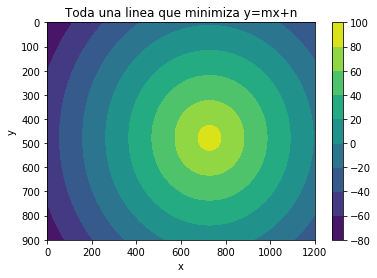

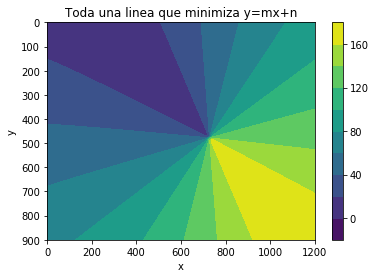

In [35]:
# result_3 = (0.09935315, -0.03387904, -0.04467695,
#              0.03, 0.007, 0.09, 2.2*10**-6, 0.006,
#             0.01311418, -0.00192129, 724, 472, 0)
plot_altura(temp_result_5)
plot_azimuth(temp_result_5)

In [56]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
# data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params[:3], *ctes[:-3], *init_params[-2:], *ctes[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = np.array([0.01, 0, 0, 0, 0])
new_params = np.array([0.09935315, -0.03387904, -0.04467695,  0.01311418, -0.00192129])
(mega_alt_xi(old_params)/len(x_exp), mega_alt_xi(new_params)/len(x_exp))

(3097.2029313855865, 2606.152930003487)

In [15]:
%matplotlib qt

plt.gca().invert_yaxis()
plt.scatter(x_exp, y_exp, c=az_catalogo, s=0.01)

In [8]:
data

,x,y,alt,az,alt_err,az_err,sample_size
23996,776,15,0.937309,308.149175,0.000000,0.000000,1
28635,771,18,0.887168,308.106391,0.000000,0.000000,1
30185,773,19,0.987568,308.191987,0.000000,0.000000,1
31742,782,20,1.388334,308.531775,0.000000,0.000000,1
31743,783,20,1.263402,308.426099,0.025442,0.021529,2
...,...,...,...,...,...,...,...
1347413,653,870,13.191352,124.805800,0.054763,0.030512,10
1348961,653,871,13.060703,124.878720,0.047067,0.026309,8
1348962,654,871,12.965081,124.932251,0.031301,0.017547,3
1350509,653,872,12.975848,124.926209,0.000000,0.000000,1


In [ ]:
"""
311 - C, A, F, V, S, D, P, Q, ep, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep = ctes
        E, X0, Y0, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep = ctes
        E, X0, Y0, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
#     new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_az_params]

In [ ]:
init_params = [0, 724, 472, 0]
ctes = [0.01, 0, 0,
         0.03, 0.007, 0.09, 2.2*10**-6, 0.006,
         0]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
# data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:-1], init_params[0], ctes[-1], *init_params[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []

In [ ]:
pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

In [ ]:
result_5 = (0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01)
plot_altura(result_5)
plot_azimuth(result_5)

In [31]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
# data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:3],*init_params, *ctes[3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
# az_catalogo = np.rad2deg(data.az.values)
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo)

print("alt: ",mega_alt_xi(temp_result_5)/len(x_exp), mega_alt_xi(temp_result_5_1)/len(x_exp))
print("az: ",mega_az_xi(temp_result_5)/len(x_exp), mega_az_xi(temp_result_5_1)/len(x_exp))

alt:  2.2899670897862214 2.2541601338255663
az:  15.733131868153018 15.803017963320222
